<a href="https://colab.research.google.com/github/noahruiz416/Tempe_Traffic_Classification/blob/main/Tempe_Traffic_Prototype_Feature_Engineering_Model_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook will contain feature engineering approaches that we will base of the V2 feature engineering notebook. Additionally we will try to engineer additional features from datetime and try to find a final best fit model using catboost 

### installing dependencies and loading libraries

In [1]:
!pip install category_encoders
!pip install catboost 
!pip install imblearn

#data loading 
import pandas as pd
import numpy as np 

#viz tools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#ml data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#evaluation metric libraries
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

#over and undersampling
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

#catboost classification model 
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 74 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### function to clean loaded data and engineer new features

In [469]:
#function to binary encode accidents as fatal or nonfatal
def encode_fatal_accidents(data):
  Severity = []
  for row in data['Injuryseverity']:
    if row != "Fatal":
      Severity.append(0) #nonfatal
    if row == "Fatal":
      Severity.append(1) #fatal
  data['Fatal_Non_Fatal'] = Severity

#drops columns that will not be used
def drop_useless_cols(data):
  return_data = data.drop(labels = ['X', 'Y',
                      'Incidentid', 'Year',
                       'Latitude', 'Longitude', 'Totalinjuries',
                       'Totalfatalities', 'Injuryseverity', 'Distance', 'OBJECTID', 'Age_Drv1', 'Age_Drv2', 'Gender_Drv1', 'Gender_Drv2'], axis = 1)
  return return_data


In [470]:
#helper function that contains the logic for whether or not drugs were involved in an accident
def label_drugs(row):
  if row['DrugUse_Drv1'] == "Drugs" or row['DrugUse_Drv2'] == "Drugs":
    return 1 #drugs are involved
  if row['DrugUse_Drv1'] != "Drugs" or row['DrugUse_Drv2'] != "Drugs":
    return 0 #drugs are not involved

#helper function that contains the logic for whether or not alch was involved in an accident
def label_alchol(row):
  if row['AlcoholUse_Drv1'] == "Alcohol" or row['AlcoholUse_Drv2'] == "Alcohol":
    return 1 #drugs are involved
  if row['AlcoholUse_Drv1'] != "Alcohol" or row['AlcoholUse_Drv2'] != "Alcohol":
    return 0 #drugs are not involved

#function to call helper functions and implement drugs / alch invovled logic
def apply_drug_alchol_label(input_data):
  data1 = input_data['drugs_involved'] = input_data.apply (lambda row: label_drugs(row), axis=1)
  data1 = input_data['alcohol_involved'] = input_data.apply (lambda row: label_alchol(row), axis=1)
  

In [596]:
#helper function to label whther or not a car was involed in an accident
def label_car(row):
  if row['Unittype_One'] == "Driver" or row['Unittype_Two'] == "Driver":
    return 1 #car was involved
  if row['Unittype_One'] != "Driver" or row['Unittype_Two'] != "Driver":
    return 0 #car was not involved

def label_cyclist(row):
  if row['Unittype_One'] == "Pedalcyclist" or row['Unittype_Two'] == "Pedalcyclist":
    return 1 #bike was involved
  if row['Unittype_One'] != "Pedalcyclist" or row['Unittype_Two'] != "Pedalcyclist":
    return 0 #bike was not involved

def label_pedestrian(row):
  if row['Unittype_One'] == "Pedestrian" or row['Unittype_Two'] == "Pedestrian":
    return 1 #Pedestrian was involved
  if row['Unittype_One'] != "Pedestrian" or row['Unittype_Two'] != "Pedestrian":
    return 0 #Pedestrian was not involved

def label_driverless(row):
  if row['Unittype_One'] == "Driverless" or row['Unittype_Two'] == "Driverless":
    return 1 #no driver was involved
  if row['Unittype_One'] != "Driverless" or row['Unittype_Two'] != "Driverless":
    return 0 #no driver was involed

#applying the above functions in one nice format 
def apply_unit_type_labels(input_data):
  data1 = input_data['Car_Involved'] = input_data.apply (lambda row: label_car(row), axis=1)
  data1 = input_data['Pedalcyclist_Involved'] = input_data.apply (lambda row: label_cyclist(row), axis=1)
  data1 = input_data['Pedestrian_Involved'] = input_data.apply (lambda row: label_pedestrian(row), axis=1)
  data1 = input_data['Driverless'] = input_data.apply (lambda row: label_driverless(row), axis=1)

In [471]:
#this function drops bad columns in light conditions, violations and collisionmanner
def drop_useless_rows(input_data):
  data1 = input_data[input_data['Lightcondition'].str.contains("51")==False]
  data2 = data1[data1['Lightcondition'].str.contains("Unknown 51")==False]
  data3 = data2[data2['Violation1_Drv1'].str.contains("108")==False]
  data4 = data3[data3['Violation1_Drv1'].str.contains("109")==False]
  data5 = data4[data4['Violation1_Drv1'].str.contains("49")==False]
  data6 = data5[data5['Collisionmanner'].str.contains("10")==False]
  return data6

In [472]:
#this function removes outlier driving ages in the data_set and then calculates the median age between the two drivers and creates a new column
def age_manipulation(input_data):
  data = input_data.drop(input_data.index[input_data['Age_Drv1'] >= 100], inplace=False)
  data1 = data.drop(data.index[data['Age_Drv2'] >= 100], inplace=False)
  data1['median_age'] = (data1['Age_Drv1'] + data1['Age_Drv2']) / 2
  return data1


In [473]:
#function to call all the cleaning methods at once
def clean_dataset(input_data):
  input_data_rows_dropped = drop_useless_rows(input_data)
  age_manipulated_data = age_manipulation(input_data_rows_dropped)
  return age_manipulated_data

In [474]:
#drops additional columns, use after calling the age manipulation function
def drop_more_cols(data):
  return_data = data.drop(labels = ['AlcoholUse_Drv1', 'AlcoholUse_Drv2', 'DrugUse_Drv1', 'DrugUse_Drv2'], axis = 1)
  return return_data

In [475]:
#converts datetime column into a categorical variable for catboost
def time(x):
    x=pd.to_datetime(x,format='%Y-%m-%d %H:%M:%S')
    if pd.to_datetime('03:00:00') < x <= pd.to_datetime('11:00:00'):
        return 'Early'
    elif pd.to_datetime('11:00:00') < x <= pd.to_datetime('17:00:00'):
        return 'Mid-day'
    return 'Late'

In [476]:
#function to use as a metric scorer
def metric_scoring(classifier, x_test_data, y_test_data):
  y_true = y_test_data
  y_pred = classifier.predict(x_test_data)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  metric_data = {
      'Precision' : precision,
      'Recall' : recall,
      'Accuracy': accuracy,
      'F1 Score': f1
  }
  return metric_data

### Cleaning our Initial Dataframe. This section takes in a 'dirty' dataframe and outputs an input dataframe as predictors and labels as our target.

In [703]:
#enables nice plots
from google.colab import output
output.enable_custom_widget_manager()

In [704]:
df = pd.read_csv("traffic_data.2.csv")

In [705]:
#the encode function simply creates our binary labels for fatal or non fatal accidents
encode_fatal_accidents(df)

#setting our clean dataset equal to our cleaned and encoded dataframe
clean_dat = clean_dataset(df)

#dropping useless cols within the clean dataset
clean_dat2_all = drop_useless_cols(clean_dat)

#applying drug and alchol labels
apply_unit_type_labels(clean_dat2_all)
apply_drug_alchol_label(clean_dat2_all)

#dropping more cols
clean_dat2_all = drop_more_cols(clean_dat2_all)

In [706]:
clean_dat2_all['DateTime'] = pd.to_datetime(clean_dat2_all['DateTime'], infer_datetime_format=True)

In [707]:
bins = ['00:00:00', '03:00:00', '11:00:00', '17:00:00', '23:59:59']
labels = ['Late', 'Early', 'Mid-Day', 'Late']

# convert to timedelta
s = pd.to_timedelta(pd.to_datetime(df['DateTime']).dt.time.astype(str))
clean_dat2_all['time_feature'] = pd.cut(s, bins=pd.to_timedelta(bins), labels=labels, ordered=False)

In [708]:
# define bins and labels for time analysis 
bins = ['00:00:00', '01:00:00' ,'06:00:00', '11:00:00', '17:00:00', '23:00:00', '23:59:59']
labels = ['Night', 'Early Morning','Morning', 'Noon', 'Evening','Night']

# convert to timedelta
s = pd.to_timedelta(pd.to_datetime(clean_dat2_all['DateTime']).dt.time.astype(str))
clean_dat2_all['time_analysis'] = pd.cut(s, bins=pd.to_timedelta(bins), labels=labels, ordered=False)
clean_dat2_all.dropna()

,DateTime,StreetName,CrossStreet,JunctionRelation,Collisionmanner,Lightcondition,Weather,SurfaceCondition,Unittype_One,Traveldirection_One,...,Fatal_Non_Fatal,median_age,Car_Involved,Pedalcyclist_Involved,Pedestrian_Involved,Driverless,drugs_involved,alcohol_involved,time_feature,time_analysis
1,2012-01-10 14:55:00,Mcclintock Dr,State Route 202 Exit 8 A-Ramp,Intersection Related Non Interchange,Rear End,Daylight,Clear,Dry,Driver,North,...,0,23.5,1,0,0,0,0,0,Mid-Day,Noon
2,2012-01-10 15:43:00,Priest Dr,Darrow Dr,Not Junction Related,Sideswipe Same Direction,Daylight,Clear,Dry,Driver,South,...,0,37.5,1,0,0,0,0,0,Mid-Day,Noon
3,2012-01-10 16:04:00,Baseline Rd,Price Rd,Intersection Related Interchange,Rear End,Daylight,Clear,Dry,Driver,East,...,0,52.5,1,0,0,0,0,0,Mid-Day,Noon
5,2012-01-10 18:45:00,Broadway Rd,Dorsey Ln,Not Junction Related,ANGLE (Front To Side)(Other Than Left Turn),Daylight,Clear,Dry,Driver,Northwest,...,0,52.0,1,0,0,0,0,0,Late,Evening
6,2012-01-10 20:04:00,Priest Dr,3rd St,Intersection Non Interchange,ANGLE (Front To Side)(Other Than Left Turn),Daylight,Clear,Dry,Driver,Northeast,...,0,29.5,1,0,0,0,0,0,Late,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39910,2020-12-31 05:08:00,University Dr,Perry Ln,Driveway Or Alley,Rear End,Dark Lighted,Clear,Dry,Driver,East,...,0,23.0,1,0,0,0,0,0,Early,Early Morning
39911,2020-12-31 14:22:00,Rural Rd,Elliot Rd,Intersection 4 Way 202,Angle - Other Than Left Turn 2,Daylight,Clear,Dry,Driver,West,...,0,50.5,1,0,0,0,0,0,Mid-Day,Noon
39912,2020-12-31 17:13:00,Broadway Rd,55th St,Intersection 4 Way 202,Left Turn,Daylight,Cloudy,Dry,Driver,West,...,0,44.0,1,0,0,0,0,0,Late,Evening
39914,2020-12-31 18:13:00,Rural Rd,Lakeshore Dr,Driveway Or Alley,U Turn,Daylight,Cloudy,Dry,Driver,North,...,0,41.5,1,0,0,0,0,0,Late,Evening


In [709]:
#having our initial input vector of all values into one dataframe
input_vector = clean_dat2_all.drop(labels = ['Fatal_Non_Fatal', 'DateTime', 'time_feature', 'Unittype_One', 'Unittype_Two'], axis = 1)


#we then load the data into to different dataframes one with our input vector and the other with train/test labels
X = input_vector
y = clean_dat2_all['Fatal_Non_Fatal']

In [710]:
X['time_analysis'] = X['time_analysis'].astype('object')
X['drugs_involved'] = X['drugs_involved'].astype('int')
X['alcohol_involved'] = X['alcohol_involved'].astype('int')

### With the dataset cleaned and new feature created, we will now begin the first baseline model with the new feature

In [499]:
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size = .20)
categorical_features_indices = np.where(x_train_cat.dtypes != float)[0]

In [ ]:
catBoost1 = CatBoostClassifier(cat_features = categorical_features_indices)

catBoost1.fit(
    x_train_cat, y_train_cat, plot=True)

In [504]:
metric_scoring(catBoost1, x_test_cat, y_test_cat)

{'Accuracy': 0.9970624613481757,
 'F1 Score': 0.0,
 'Precision': 0.0,
 'Recall': 0.0}

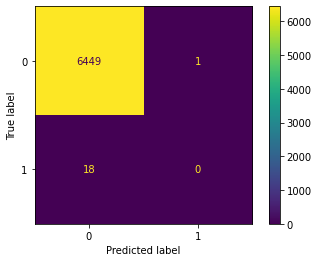

In [505]:
ConfusionMatrixDisplay.from_estimator(catBoost1, x_test_cat, y_test_cat)

<Figure size 20000x10000 with 0 Axes>

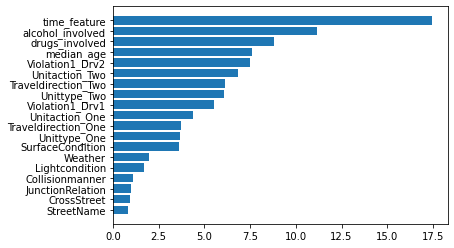

<Figure size 20000x10000 with 0 Axes>

In [506]:
cat_features_1 = catBoost1.feature_importances_
plt.barh(x_test_cat.columns, sorted(catBoost1.feature_importances_))
figure(figsize=(40, 20), dpi=500)

### Iteration 2 Increasing positive scale rate to match minority to majority class ratio

In [ ]:
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size = .20)
categorical_features_indices = np.where(x_train_cat.dtypes != float)[0]

In [ ]:
catBoost2 = CatBoostClassifier(cat_features = categorical_features_indices, scale_pos_weight= 400)

catBoost2.fit(
    x_train_cat, y_train_cat, plot=True)

In [ ]:
metric_scoring(catBoost2, x_test_cat, y_test_cat)

{'Accuracy': 0.9965986394557823,
 'F1 Score': 0.35294117647058826,
 'Precision': 0.375,
 'Recall': 0.3333333333333333}

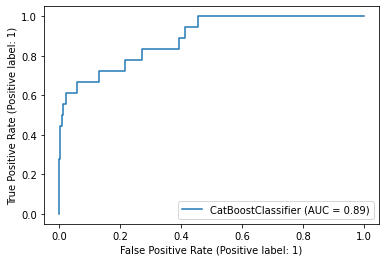

In [ ]:
RocCurveDisplay.from_estimator(catBoost2, x_test_cat, y_test_cat)

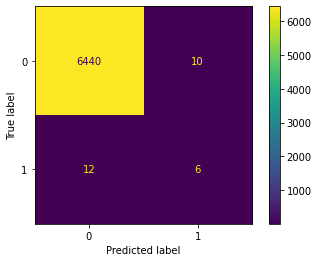

In [ ]:
ConfusionMatrixDisplay.from_estimator(catBoost2, x_test_cat, y_test_cat)

###Iteration 3 utilizing same class scale, but utilizing a bit of smote to oversample

In [138]:
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size = .20)
categorical_features_indices = np.where(x_train_cat.dtypes != float)[0]

catBoost3 = CatBoostClassifier(cat_features = categorical_features_indices, scale_pos_weight=(1500))

smote = SMOTENC(categorical_features_indices, sampling_strategy=(.10))

In [139]:
#creating oversampled smote classes
x_train_cat_res, y_train_cat_res = smote.fit_resample(x_train_cat, y_train_cat)

In [140]:
y_train_cat_res.value_counts()

0    25811
1     2581
Name: Fatal_Non_Fatal, dtype: int64

In [ ]:
#fitting smote classes
catBoost3.fit(
    x_train_cat_res, y_train_cat_res, plot=True)

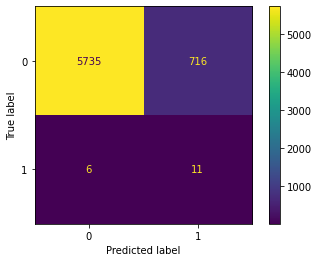

In [142]:
ConfusionMatrixDisplay.from_estimator(catBoost3, x_test_cat, y_test_cat)

In [143]:
metric_scoring(catBoost3, x_test_cat,y_test_cat)

{'Accuracy': 0.8883735312306741,
 'F1 Score': 0.02956989247311828,
 'Precision': 0.015130674002751032,
 'Recall': 0.6470588235294118}

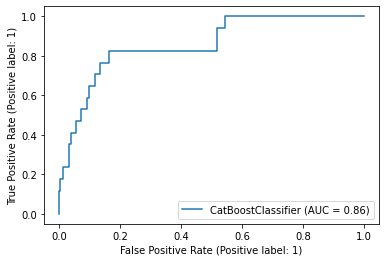

In [144]:
RocCurveDisplay.from_estimator(catBoost3, x_test_cat, y_test_cat)

## Iteration 4 Using Same model as above but with optimal hyperparameters

In [ ]:
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(X, y, test_size = .20)
categorical_features_indices = np.where(x_train_cat.dtypes != float)[0]

catboost4 = CatBoostClassifier(cat_features=categorical_features_indices, scale_pos_weight=1500, 
                               depth = 10, l2_leaf_reg = 7, learning_rate = 0.1)

smote = SMOTENC(categorical_features_indices, sampling_strategy=(.10))

In [ ]:
#artifical classes
x_train_cat_res, y_train_cat_res = smote.fit_resample(x_train_cat, y_train_cat)

In [ ]:
#fitting smote classes
catboost4.fit(
    x_train_cat_res, y_train_cat_res, plot=True)

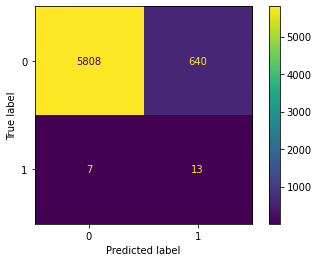

In [ ]:
ConfusionMatrixDisplay.from_estimator(catboost4, x_test_cat, y_test_cat)

In [ ]:
metric_scoring(catboost4, x_test_cat,y_test_cat)

{'Accuracy': 0.8999690785405071,
 'F1 Score': 0.03863298662704309,
 'Precision': 0.019908116385911178,
 'Recall': 0.65}

## Optimal Hyperparameters ended up decreasing performance, so we will instead try to Cross validate the third model

In [27]:
categorical_features_indices = np.where(X.dtypes != float)[0]

In [28]:
#SMOTE w/ cross fold leads to overfitting on recall
smote = SMOTENC(categorical_features_indices, sampling_strategy=(.10))

X_res, y_res = smote.fit_resample(X, y)

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

stratKFold = StratifiedKFold(n_splits=5)
model= CatBoostClassifier(cat_features = categorical_features_indices, scale_pos_weight=(1500))

results = cross_validate(estimator=model,
                                          X=X,
                                          y=y,
                                          cv=stratKFold,
                                          scoring=scoring)

In [33]:
display(results)

{'fit_time': array([ 93.67005277, 105.03599882,  91.10375905,  89.74690509,
         89.90470028]),
 'score_time': array([0.28943849, 0.08636642, 0.08739328, 0.17564297, 0.10582685]),
 'test_accuracy': array([0.99690785, 0.99737168, 0.99427953, 0.99474335, 0.99768089]),
 'test_f1_score': array([0.23076923, 0.26086957, 0.13953488, 0.10526316, 0.28571429]),
 'test_precision': array([0.27272727, 0.375     , 0.11111111, 0.09090909, 0.6       ]),
 'test_recall': array([0.2   , 0.2   , 0.1875, 0.125 , 0.1875])}

### Iteration 6, undersamle majority class, run model again

In [560]:
#undersample class
categorical_features_indices = np.where(X.dtypes != float)[0]
rs = RandomUnderSampler()
x_under, y_under = rs.fit_resample(X, y)

In [ ]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

stratKFold = StratifiedKFold(n_splits=5)
model= CatBoostClassifier(cat_features = categorical_features_indices)

results = cross_validate(estimator=model,
                                          X=x_under,
                                          y=y_under,
                                          cv=stratKFold,
                                          scoring=scoring)

In [42]:
display(results)

{'fit_time': array([18.12573719, 12.71800375,  8.98953342,  8.55307961,  9.01791263]),
 'score_time': array([0.00949287, 0.00546765, 0.00616813, 0.00660396, 0.00543308]),
 'test_accuracy': array([0.71875   , 0.83870968, 0.83870968, 0.83870968, 0.77419355]),
 'test_f1_score': array([0.66666667, 0.84848485, 0.8       , 0.82758621, 0.75862069]),
 'test_precision': array([0.81818182, 0.77777778, 1.        , 0.92307692, 0.84615385]),
 'test_recall': array([0.5625    , 0.93333333, 0.66666667, 0.75      , 0.6875    ])}

In [ ]:
#making predictions
y_pred_under = cross_val_predict(estimator=model,
                                          X=x_under,
                                          y=y_under,
                                          cv=stratKFold
                                          )

In [46]:
confusion_matrix(y_under, y_pred_under)

array([[69,  9],
       [22, 56]])

### Iteration 7, adding train test split to the model above (As of Now best fit model)

In [658]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [659]:
#undersample class
rs = RandomUnderSampler()
x_under_train, y_under_train = rs.fit_resample(X = x_train, y = y_train)

In [ ]:
#fitting model
categorical_features_indices = np.where(X.dtypes != float)[0]

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

stratKFold = StratifiedKFold(n_splits=5)
model= CatBoostClassifier(cat_features = categorical_features_indices, scale_pos_weight=1.10)

results = cross_validate(estimator=model,
                                          X=x_under_train,
                                          y=y_under_train,
                                          cv=stratKFold,
                                          scoring=scoring)

In [661]:
display(results)

{'fit_time': array([9.16647291, 8.59604263, 9.84881783, 8.58690071, 8.93741059]),
 'score_time': array([0.00603604, 0.00593472, 0.00575113, 0.00610304, 0.00580883]),
 'test_accuracy': array([0.92592593, 0.77777778, 0.96153846, 0.73076923, 0.88461538]),
 'test_f1_score': array([0.92307692, 0.76923077, 0.96      , 0.72      , 0.88888889]),
 'test_precision': array([0.92307692, 0.83333333, 1.        , 0.75      , 0.85714286]),
 'test_recall': array([0.92307692, 0.71428571, 0.92307692, 0.69230769, 0.92307692])}

In [ ]:
#fitting the model
model_fitted = model.fit(x_under_train, y_under_train)

In [ ]:
ConfusionMatrixDisplay.from_estimator(model_fitted, x_test, y_test)

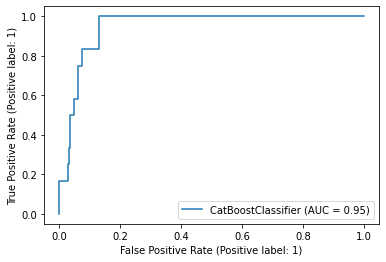

In [664]:
RocCurveDisplay.from_estimator(model_fitted, x_test, y_test)

In [665]:
metric_scoring(model_fitted, x_test, y_test)

{'Accuracy': 0.8803339517625232,
 'F1 Score': 0.025188916876574305,
 'Precision': 0.01278772378516624,
 'Recall': 0.8333333333333334}

### Iteration 8 Using Random Over, then under sampling 

In [337]:
from imblearn.over_sampling import RandomOverSampler

#train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [338]:
#undersample class
rs = RandomUnderSampler()
x_under_train, y_under_train = rs.fit_resample(X = x_train, y = y_train)

In [339]:
y_under_train.value_counts()

0    62
1    62
Name: Fatal_Non_Fatal, dtype: int64

In [ ]:
#fitting model
categorical_features_indices = np.where(X.dtypes != float)[0]

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

stratKFold = StratifiedKFold(n_splits=5)
model= CatBoostClassifier(cat_features = categorical_features_indices)

results = cross_validate(estimator=model,
                                          X=x_under_train,
                                          y=y_under_train,
                                          cv=stratKFold,
                                          scoring=scoring)

In [313]:
display(results)

{'fit_time': array([20.76758957, 16.94022036, 17.4535656 , 17.83868337, 19.68367219]),
 'score_time': array([0.01147938, 0.01143718, 0.01260829, 0.00997019, 0.0351882 ]),
 'test_accuracy': array([1.        , 0.99806202, 1.        , 0.99224806, 0.99612403]),
 'test_f1_score': array([1.        , 0.99806576, 1.        , 0.99230769, 0.996139  ]),
 'test_precision': array([1.        , 0.996139  , 1.        , 0.98473282, 0.99230769]),
 'test_recall': array([1., 1., 1., 1., 1.])}

In [ ]:
#fitting the model
model_fitted = model.fit(x_under_train, y_under_train)

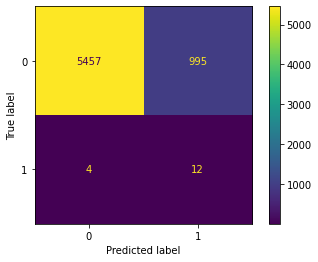

In [341]:
ConfusionMatrixDisplay.from_estimator(model_fitted, x_test, y_test)

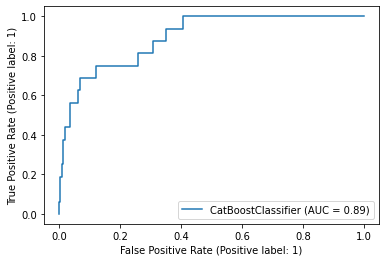

In [342]:
RocCurveDisplay.from_estimator(model_fitted, x_test, y_test)

In [343]:
metric_scoring(model_fitted, x_test, y_test)

{'Accuracy': 0.8455473098330241,
 'F1 Score': 0.02346041055718475,
 'Precision': 0.011916583912611719,
 'Recall': 0.75}

### Iteration 9 Scale Pos Weight, no undersample + CV fold

In [545]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [542]:
y_train_len_pos = sum(y_train == 1)

In [544]:
y_train_len_neg = len(y_train == 0) - y_train_len_pos

In [552]:
(y_train_len_neg / y_train_len_pos)

416.2903225806452

In [ ]:
#fitting model
categorical_features_indices = np.where(X.dtypes != float)[0]

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

stratKFold = StratifiedKFold(n_splits=5)
model= CatBoostClassifier(cat_features = categorical_features_indices, scale_pos_weight = 1000)

results = cross_validate(estimator=model,
                                          X=X,
                                          y=y,
                                          cv=stratKFold,
                                          scoring=scoring)

In [557]:
display(results)

{'fit_time': array([87.92940927, 86.82948565, 87.7690146 , 86.64457059, 89.67869329]),
 'score_time': array([0.09883189, 0.10545707, 0.09928632, 0.09305501, 0.11800098]),
 'test_accuracy': array([0.99489796, 0.99304267, 0.99025974, 0.99319728, 0.99659864]),
 'test_f1_score': array([0.15384615, 0.21052632, 0.1369863 , 0.15384615, 0.21428571]),
 'test_precision': array([0.125     , 0.14285714, 0.0877193 , 0.11111111, 0.25      ]),
 'test_recall': array([0.2   , 0.4   , 0.3125, 0.25  , 0.1875])}

In [ ]:
model_fitted = model.fit(x_train, y_train)

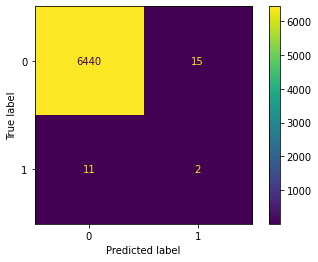

In [549]:
ConfusionMatrixDisplay.from_estimator(model_fitted, x_test, y_test)

In [550]:
metric_scoring(model_fitted, x_test, y_test)

{'Accuracy': 0.9959802102659245,
 'F1 Score': 0.13333333333333333,
 'Precision': 0.11764705882352941,
 'Recall': 0.15384615384615385}

### Attempting using RF Classifier and SVM once more time but with undersampling or oversampling

In [346]:
#takes in a training dataset and encodes it into a frequency encoding
def freq_code(train_data):
  #seperating features into categorical and numerical
  cat_features_input = train_data.select_dtypes(['object'])
  numerical_features_input = train_data.select_dtypes(['int', 'float'])

  #encoding cat_features
  encdoer = CountEncoder(return_df = True)
  cat_features_input_encoded = encdoer.fit_transform(cat_features_input)

  #concat df back together
  converted_data = pd.concat([numerical_features_input, cat_features_input_encoded], axis =1)

  return converted_data

In [348]:
#pipelines
from sklearn.pipeline import Pipeline

#models for pipelines
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#cat encoders
from category_encoders import CountEncoder
from category_encoders import SumEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [399]:
x_train_freq, x_test_freq, y_train_freq, y_test_freq = train_test_split(X, y, test_size = .20)

In [400]:
x_train_freq = freq_code(x_train_freq)

In [401]:
pipe_rf = Pipeline([('rf_classifier',RandomForestClassifier())])
pipe_svm = Pipeline([('svm_classifier',SVC())])

In [402]:
pipelines = [pipe_rf, pipe_svm]

for pipe in pipelines: 
  pipe.fit(x_train_freq, y_train_freq)

In [403]:
x_test_freq = freq_code(x_test_freq)

In [404]:
#rf scoring
metric_scoring(pipelines[0],x_test_freq, y_test_freq)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.9976808905380334,
 'F1 Score': 0.0,
 'Precision': 0.0,
 'Recall': 0.0}

In [405]:
#rf scoring
metric_scoring(pipelines[1],x_test_freq, y_test_freq)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.9976808905380334,
 'F1 Score': 0.0,
 'Precision': 0.0,
 'Recall': 0.0}

In [362]:
#undersample class
rs = RandomUnderSampler()
x_under_train, y_under_train = rs.fit_resample(X = x_train_freq, y = y_train_freq)

In [363]:
for pipe in pipelines: 
  pipe.fit(x_under_train, y_under_train)


In [364]:
metric_scoring(pipelines[0],x_test_freq, y_test_freq)

{'Accuracy': 0.0027829313543599257,
 'F1 Score': 0.005550416281221091,
 'Precision': 0.0027829313543599257,
 'Recall': 1.0}

In [365]:
metric_scoring(pipelines[1],x_test_freq, y_test_freq)

{'Accuracy': 0.0027829313543599257,
 'F1 Score': 0.005550416281221091,
 'Precision': 0.0027829313543599257,
 'Recall': 1.0}

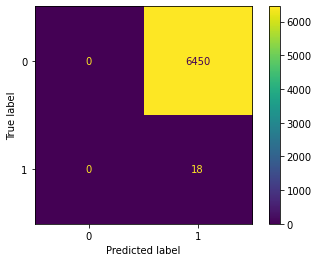

In [366]:
ConfusionMatrixDisplay.from_estimator(pipelines[0], x_test_freq, y_test_freq)

### Quick PCA to check dimensionality 

In [515]:
input_vector = clean_dat2_all.drop(labels = ['DateTime', 'time_feature'], axis = 1)

In [516]:
test_pca = freq_code(input_vector)

In [517]:
test_pca = (test_pca - test_pca.mean()) / (test_pca.std())

In [518]:
from sklearn.decomposition import PCA

In [519]:
pca = PCA(n_components=2)
pca.fit(test_pca)

PCA(n_components=2)

In [520]:
reduced = pca.transform(test_pca)

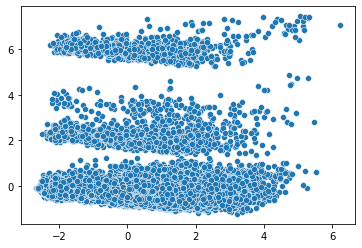

In [521]:
sns.scatterplot(x = reduced[:,0], y = reduced[:,1])

## Model with Different Time Scaling Feature 

In [ ]:
#train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#undersample class
rs = RandomUnderSampler()
x_under_train, y_under_train = rs.fit_resample(X = x_train, y = y_train)

In [ ]:
#fitting model
categorical_features_indices = np.where(X.dtypes != float)[0]

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

stratKFold = StratifiedKFold(n_splits=5)
model= CatBoostClassifier(cat_features = categorical_features_indices, scale_pos_weight= (1.1))

results = cross_validate(estimator=model,
                                          X=x_under,
                                          y=y_under,
                                          cv=stratKFold,
                                          scoring=scoring)

In [ ]:
display(results)

In [ ]:
#fitting the model
model_fitted = model.fit(x_under_train, y_under_train)

In [ ]:
ConfusionMatrixDisplay.from_estimator(model_fitted, x_test, y_test)

In [ ]:
RocCurveDisplay.from_estimator(model_fitted, x_test, y_test)

In [ ]:
metric_scoring(model_fitted, x_test, y_test)